In [1]:
pwd

'/data2/mito_lineage/src/clones'

In [2]:
import os
os.chdir("/data2/mito_lineage")

In [3]:
from os.path import join, exists, dirname
from glob import glob
import pickle
import mplh.cluster_help as ch
import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)

import pandas as pd
import seaborn as sns
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

from src.external.pyvenn import venn


%load_ext autoreload
%autoreload 2
import src.utils.variant_utils as vu
from src.utils.data_io import wrap_load_mtx_df
from src.utils.variant_utils import get_high, get_low
from icecream import ic

0.5.6


In [4]:
import src.utils.variant_utils as vu

In [5]:
from src.utils.data_io import wrap_load_mtx_df

In [6]:
INDIR = "/data/isshamie/mito_lineage/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_mgatkdonor/vireo/donor0/mgatk_donor/"
col = "lineage"
filt_col = "donor"
filt_val = 0
cells_meta_f = "/data/isshamie/mito_lineage/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_mgatkdonor/vireo/nclones20/cells_meta.tsv"

OUTDIR = "/data/isshamie/mito_lineage/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_mgatkdonor/vireo/nclones20/qc"

# Params
vars_to_plot=10
sample_names="Control,Flt3l"
N_DONORS=4

In [7]:
sample_names = sample_names.split(",")

In [8]:
cells_meta = pd.read_csv(cells_meta_f, sep='\t')
cells_meta=cells_meta.astype({"donor_index": "Int64", "donor": "Int64", "lineage":"Int64", "lineage_index":"Int64"})
cells_meta = cells_meta.set_index("ID")
cells_meta
#cells_meta.head()

,index,raw ID,new index,condition,donor,donor_index,lineage,lineage_index
ID,,,,,,,,
AACGAGGGTCATAGCT-1_pre,182,AACGAGGGTCATAGCT-1,183,pre,0,81,0,1
ACAATCGTCCCTACCA-1_pre,403,ACAATCGTCCCTACCA-1,404,pre,0,186,0,2
ACCATCCGTAAGTCTC-1_pre,489,ACCATCCGTAAGTCTC-1,490,pre,0,231,0,3
ACTACCCGTTGTGACT-1_pre,617,ACTACCCGTTGTGACT-1,618,pre,0,293,0,4
ACTGTCCCACATCATG-1_pre,699,ACTGTCCCACATCATG-1,700,pre,0,327,0,5
...,...,...,...,...,...,...,...,...
TTTGCGCTCTTAAGCG-1_post,15540,TTTGCGCTCTTAAGCG-1,15541,post,1,7998,<NA>,<NA>
TTTGGCCCAAGAGCGT-1_post,15547,TTTGGCCCAAGAGCGT-1,15548,post,1,8000,<NA>,<NA>
TTTGGTTAGCAACGGT-1_post,15558,TTTGGTTAGCAACGGT-1,15559,post,1,8006,<NA>,<NA>


In [9]:
vcf_f = join(INDIR, "cellSNP.base.vcf")
vcf=pd.read_csv(vcf_f,
                sep='\t').fillna("N")
vcf.index = vcf.apply(lambda x: str(x["POS"])+x["REF"] + ">" + x["ALT"],axis=1)
vcf.head()

,#CHROM,POS,REF,ALT,strand_correlation,vmr,n_cells_over_5,n_cells_over_20,index
4949A>G,chrM,49,49A,G,0.950503,0.044152,49,1,49A>G
5757T>C,chrM,57,57T,C,0.929782,0.066010,17,0,57T>C
5757T>G,chrM,57,57T,G,0.925839,0.052215,5,0,57T>G
5858T>C,chrM,58,58T,C,0.720949,0.053133,16,0,58T>C
6464C>T,chrM,64,64C,T,0.966397,0.164957,437,39,64C>T


In [10]:
af, dp = wrap_load_mtx_df(INDIR, oth_f=False, prefix="cellSNP.tag",
                     columns=('Variant', 'Cell', 'integer'), inc_af=True,
                     as_dense=True, var_names=True, vcf_prefix="cellSNP.base",
                     verbose=True, cell_names=True)

ic| prefix: 'cellSNP.tag'


# 1. Create variants qc for each lineage+condition

### Create filtered cells meta and sorted

In [11]:
curr_cells_meta = cells_meta[cells_meta[filt_col] == filt_val].sort_values(f"{filt_col}_index").dropna()
curr_cells_meta

,index,raw ID,new index,condition,donor,donor_index,lineage,lineage_index
ID,,,,,,,,
AAACGAAAGGCTCCTG-1_pre,1,AAACGAAAGGCTCCTG-1,2,pre,0,1,2,1
AAACGAAAGTGAATAC-1_pre,3,AAACGAAAGTGAATAC-1,4,pre,0,2,17,1
AAACGAAAGTGTCACT-1_pre,4,AAACGAAAGTGTCACT-1,5,pre,0,3,2,2
AAACGAACATAGGCGA-1_pre,6,AAACGAACATAGGCGA-1,7,pre,0,4,17,2
AAACTCGAGTGTCACT-1_pre,12,AAACTCGAGTGTCACT-1,13,pre,0,6,17,3
...,...,...,...,...,...,...,...,...
TTTGTGTGTATCTGCA-1_post,15580,TTTGTGTGTATCTGCA-1,15581,post,0,6741,17,3849
TTTGTGTGTCCCTTTG-1_post,15581,TTTGTGTGTCCCTTTG-1,15582,post,0,6742,17,3850
TTTGTGTTCAAAGTAG-1_post,15583,TTTGTGTTCAAAGTAG-1,15584,post,0,6743,17,3851


/data/isshamie/software/anaconda3/envs/mito_trace/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


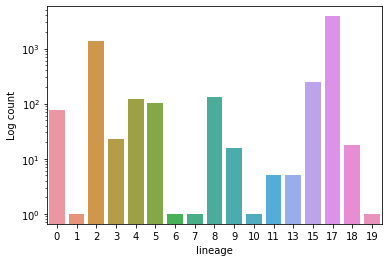

In [29]:
sns.countplot(curr_cells_meta["lineage"], )
plt.ylabel("Log count")
plt.yscale("log")

### Create dictionary where key is lineage_condition and value is list of cells
### Filter any with less than 5 cells

In [12]:
groups_d = {}
for ind, val in curr_cells_meta.groupby(["lineage", "condition"]):
    if len(val.index.values) > 10:
        groups_d[f"{ind[0]}_{ind[1]}"] = val.index.values

lin_d = {}
for ind, val in curr_cells_meta.groupby(["lineage"]):
    if len(val.index.values) > 10:
        lin_d[str(ind)] = val.index.values



In [13]:
all_vars_qc_df, all_vars_qc = vu.variants_qc(af, dp, groups_d)

group 0_post
group 0_pre
group 2_post
group 2_pre
group 3_post
group 4_post
group 4_pre
group 5_post
group 5_pre
group 8_post
group 8_pre
group 15_post
group 15_pre
group 17_post
group 17_pre
group 18_post


In [14]:
all_vars_qc_df

,group,lineage,mean,std,depth mean,depth number_1,depth number_5,depth number_10,perc_0.01,number_0.01,perc_0.05,number_0.05,perc_0.1,number_0.1,perc_0.9,number_0.9,depth std,meta,variant,condition
4949A>G,0_post,0,0.000000,0.000000,67.217391,46,46,46,0.000000,0,0.000000,0,0.000000,0,0.000000,0,29.456494,Group,4949A>G,post
5757T>C,0_post,0,0.000000,0.000000,63.282609,46,46,46,0.000000,0,0.000000,0,0.000000,0,0.000000,0,27.322488,Group,5757T>C,post
5757T>G,0_post,0,0.000000,0.000000,63.282609,46,46,46,0.000000,0,0.000000,0,0.000000,0,0.000000,0,27.322488,Group,5757T>G,post
5858T>C,0_post,0,0.002174,0.011256,63.108696,46,46,46,0.043478,2,0.021739,1,0.000000,0,0.000000,0,27.589232,Group,5858T>C,post
6464C>T,0_post,0,0.010815,0.023930,63.586957,46,46,46,0.195652,9,0.108696,5,0.000000,0,0.000000,0,26.038925,Group,6464C>T,post
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638716387A>G,18_post,18,0.002577,0.010827,85.202139,6733,6732,6732,0.076935,518,0.010842,73,0.001485,10,0.000000,0,52.452516,Other,1638716387A>G,post
1651216512T>G,18_post,18,0.000227,0.003404,82.077083,6733,6732,6732,0.006238,42,0.001188,8,0.000149,1,0.000000,0,50.426713,Other,1651216512T>G,post
1651216512T>A,18_post,18,0.002192,0.010521,82.077083,6733,6732,6732,0.066241,446,0.009802,66,0.001040,7,0.000000,0,50.426713,Other,1651216512T>A,post
1651916519T>A,18_post,18,0.000275,0.003835,79.556216,6733,6732,6730,0.008020,54,0.001485,10,0.000149,1,0.000000,0,48.531605,Other,1651916519T>A,post


# Filter for top variants and plot across conditions

### F1. > 10 cells with >0.01 AF

/data/isshamie/software/anaconda3/envs/mito_trace/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


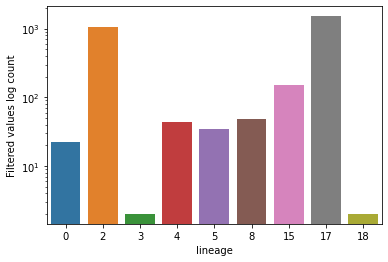

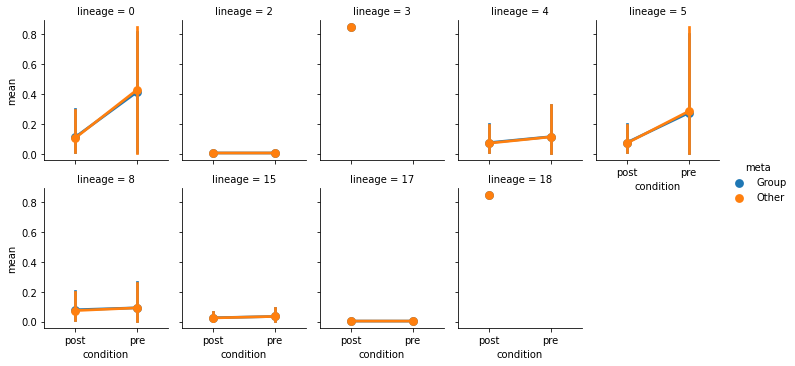

In [32]:
tmp_all_vars = all_vars_qc_df.set_index(['group', 'variant'])
tmp_all_vars = vu.filter_variants(tmp_all_vars[tmp_all_vars['meta']=='Group'], thresh=10, thresh_col='number_0.01')
f1 = all_vars_qc_df.set_index(['group', 'variant']).loc[tmp_all_vars.index].reset_index()
f1

sns.countplot(f1["lineage"])
plt.ylabel("Filtered values log count")
plt.yscale("log")

g = sns.catplot(x="condition", y="mean", col="lineage", col_wrap=5,
                data=f1, kind="point", hue="meta",
                height=2.5, aspect=.8)

### F1. >10% with > 0.01 AF

/data/isshamie/software/anaconda3/envs/mito_trace/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


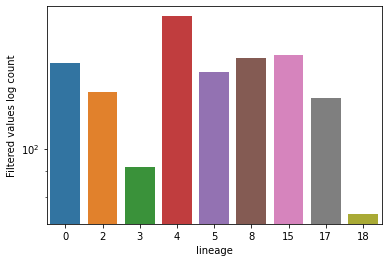

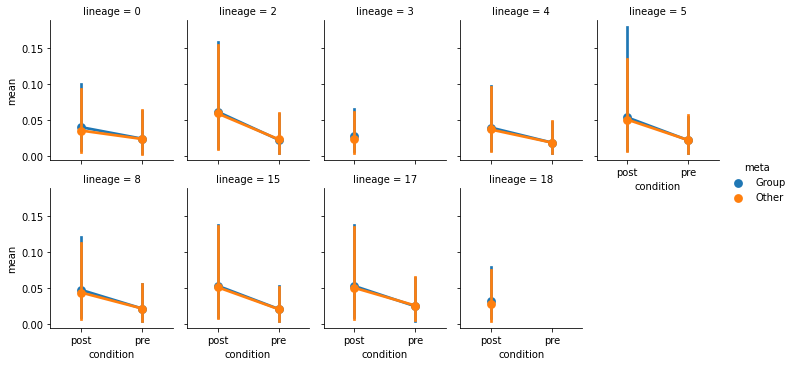

In [33]:
tmp_all_vars = all_vars_qc_df.set_index(['group', 'variant'])
tmp_all_vars = vu.filter_variants(tmp_all_vars[tmp_all_vars['meta']=='Group'], thresh=0.10, thresh_col='perc_0.01')
f2 = all_vars_qc_df.set_index(['group', 'variant']).loc[tmp_all_vars.index].reset_index()
f2

sns.countplot(f2["lineage"])
plt.ylabel("Filtered values log count")
plt.yscale("log")

g = sns.catplot(x="condition", y="mean", col="lineage", col_wrap=5,
                data=f2, kind="point", hue="meta",
                height=2.5, aspect=.8)